In [1]:
import mysql.connector
import pandas as pd

In [2]:
class mysqlconnector:
    
    def __init__(self, database = 'book'):
        try:
            connection = mysql.connector.connect(host = 'localhost',
                                                user = 'root',
                                                password = '',
                                                use_pure = True,
                                                database = database
                                                )
            if connection.is_connected:
                db_info = connection.get_server_info()
                print('connected to MYSQL server version', db_info)
                print('You are connected to the database:', database)
                self.connection = connection
        except Exception as e:
            print('Error while connecting to MYSQL', e)
            
    def execute(self, query, header = False):
        cursor = self.connection.cursor(buffered = True)
        cursor.execute(query)
        
        try:
            record = cursor.fetchall()
            
            if header:
                header = [i[0] for i in cursor.description]
                return {'header': header, 'record': record}
            else:
                return record
        except:
            pass
        
        
    def to_db(self, query):
        result = self.execute(query, header = True)
        df = pd.DataFrame(result['record'])
        df.columns = result['header']
        return df

In [3]:
db = mysqlconnector('book')

connected to MYSQL server version 5.5.5-10.4.24-MariaDB
You are connected to the database: book


In [4]:
query = """
        SELECT * FROM users
        """

df1 = db.to_db(query)
df1.sample(5)

,user_id,location,age
158584,158585,"plano, texas, usa",15.0
171194,171195,"wilkes-barre, pennsylvania, usa",NaN
154916,154917,"stow, ohio, usa",NaN
183373,183374,"garden grove, california, usa",21.0
6944,6945,"austin, texas, usa",26.0


In [5]:
query = """
        SELECT * FROM books
        """

df2 = db.to_db(query)
df2.sample(5)

,book_id,title,author,YOP,publisher
152828,0375756728,Little Women (Modern Library Classics),Louisa May Alcott,2001,Modern Library
100856,047119297X,The Magical Maze : Seeing the World Through Ma...,Ian Stewart,1998,Wiley
247132,044667883X,Last Man Standing,David Baldacci,2001,Warner Books
6331,0688160867,Sideways Stories from Wayside School,Louis Sachar,1998,HarperCollins
177257,3492265030,Hexensturm.,Sean Stewart,2003,Piper


In [6]:
query = """
        SELECT * FROM ratings
        """

df3 = db.to_db(query)
df3.sample(5)

,user_id,book_id,book_rating
535129,129074,0525432922,0
470520,112559,0020088248,8
720996,174304,0934998191,0
699637,170513,0451526333,0
863555,208815,0671795937,0


In [7]:
print(df1.shape, df2.shape, df3.shape)

(278858, 3) (271379, 5) (1149780, 3)


In [8]:
df2.dtypes

book_id      object
title        object
author       object
YOP           int64
publisher    object
dtype: object

### YOP cleaning

In [9]:
import numpy as np

np.sort(df2['YOP'].unique())

array([   0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908,
       1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924,
       1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935,
       1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946,
       1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021,
       2024, 2026, 2030, 2037, 2038, 2050], dtype=int64)

In [10]:
# To diplay full text in the column of the dataframe
pd.set_option('display.max_colwidth', None)

In [11]:
df2[df2['book_id'] == '078946697X']

,book_id,title,author,YOP,publisher
209550,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)""",Michael Teitelbaum,2000,DK Publishing Inc


In [12]:
df2[df2['book_id'] == '2070426769']

,book_id,title,author,YOP,publisher
220744,2070426769,"Peuple du ciel, suivi de 'Les Bergers""",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard


In [13]:
# Since the dataset was published on 2004 hence all the YOP above 2006(with two years of margin) can be considered as the error

import numpy as np

df2.loc[(df2['YOP'] > 2006) | (df2['YOP'] == 0), 'YOP'] = np.NaN

In [14]:
df2['YOP'].isna().value_counts()

False    266737
True       4642
Name: YOP, dtype: int64

### Publisher cleaning

In [15]:
df2['publisher'].isna().value_counts()

False    271379
Name: publisher, dtype: int64

In [16]:
df2[df2['publisher'] == 'N/A']

,book_id,title,author,YOP,publisher
128896,193169656X,Tyrant Moon,Elaine Corvidae,2002.0,N/A
129043,1931696993,Finders Keepers,Linnea Sinclair,2001.0,N/A


In [17]:
# Checking clues from title and author for 'N/A' values

df2[df2['title'] == 'Tyrant Moon']

,book_id,title,author,YOP,publisher
128896,193169656X,Tyrant Moon,Elaine Corvidae,2002.0,N/A


In [18]:
df2[df2['author'] == 'Elaine Corvidae']

,book_id,title,author,YOP,publisher
126768,1931696934,Winter's Orphans,Elaine Corvidae,2001.0,Novelbooks
128896,193169656X,Tyrant Moon,Elaine Corvidae,2002.0,N/A
129007,0759901880,Wolfkin,Elaine Corvidae,2001.0,Hard Shell Word Factory


In [19]:
df2[df2['title'] == 'Finders Keepers']

,book_id,title,author,YOP,publisher
10800,082177364X,Finders Keepers,Fern Michaels,2002.0,Zebra Books
42020,0070465037,Finders Keepers,Barbara Nickolae,1989.0,McGraw-Hill Companies
58267,0688118461,Finders Keepers,Emily Rodda,1993.0,Harpercollins Juvenile Books
66681,1575663236,Finders Keepers,Fern Michaels,1998.0,Kensington Publishing Corporation
129043,1931696993,Finders Keepers,Linnea Sinclair,2001.0,N/A
134315,0156309505,Finders Keepers,Will,1989.0,Voyager Books
173482,0973146907,Finders Keepers,Sean M. Costello,2002.0,Red Tower Publications
195896,0061083909,Finders Keepers,Sharon Sala,2003.0,HarperTorch
211886,0373261160,Finders Keepers,Elizabeth Travis,1993.0,Worldwide Library


In [20]:
df2[df2['author'] == 'Linnea Sinclair']

,book_id,title,author,YOP,publisher
129043,1931696993,Finders Keepers,Linnea Sinclair,2001.0,N/A


### Users cleaning

In [21]:
df1.head()

,user_id,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [22]:
df1.dtypes

user_id       int64
location     object
age         float64
dtype: object

In [23]:
df1.shape

(278858, 3)

In [24]:
df1['age'].isna().value_counts()

False    168096
True     110762
Name: age, dtype: int64

In [25]:
np.sort(df1['age'].unique())

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 113., 114., 115., 116., 118., 119., 123., 124., 127.,
       128., 132., 133., 136., 137., 138., 140., 141., 143., 146., 147.,
       148., 151., 152., 156., 157., 159., 162., 168., 172., 175., 183.,
       186., 189., 199., 200., 201., 204., 207., 20

In [26]:
# Age above 90 and below seems to be erroneous

df1[(df1['age'] > 90) | (df1['age'] < 5)].shape

(1312, 3)

### Ratings cleaning

In [27]:
df3.head()

,user_id,book_id,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [28]:
df3.shape

(1149780, 3)

In [29]:
df3['book_rating'].unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2], dtype=int64)

In [30]:
# matching user_id from users to ratings dataset

df3[df3['user_id'].isin(df1['user_id'])].shape

(1149780, 3)

In [31]:
# matching book_id from books to rating dataset

df3[df3['book_id'].isin(df2['book_id'])].shape

(1031175, 3)

In [32]:
df4 = df3[df3['book_id'].isin(df2['book_id'])]

df4.head()

,user_id,book_id,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [33]:
print('rating matrix should have {} entries'.format(df1.shape[0]*df2.shape[0]),'\n',
      'however, df4 have {} entries'.format(df4.shape[0]),'\n',
      'sparsity = {} %'.format(100 - df4.shape[0]*100/(df1.shape[0]*df2.shape[0])))

rating matrix should have 75676205182 entries 
 however, df4 have 1031175 entries 
 sparsity = 99.99863738542713 %


In [34]:
# book_ratings with 0 values are implicit rating and 1-10 are explicit ratings

df4_implicit = df4[df4['book_rating'] == 0]
df4_explicit = df4[df4['book_rating'] != 0]

In [35]:
print(df4_implicit.shape, df4_explicit.shape)

(647323, 3) (383852, 3)


<AxesSubplot:>

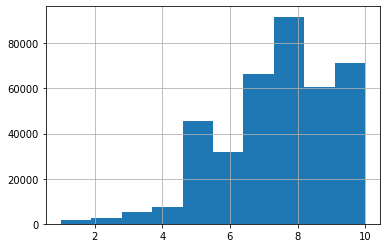

In [36]:
import matplotlib.pyplot as plt

df4_explicit['book_rating'].hist(bins = 10)

<AxesSubplot:xlabel='book_rating', ylabel='count'>

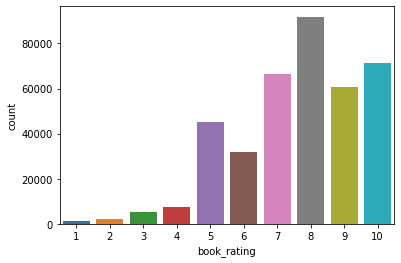

In [37]:
import seaborn as sns

sns.countplot(data = df4_explicit, x = 'book_rating')

# Popularity based recommendation

In [38]:
pop_rat = pd.DataFrame(df4_explicit.groupby('book_id')['book_rating'].sum())

In [39]:
pop_10_books = pop_rat.sort_values('book_rating', ascending = False)[:10]
pop_10_books.head()

,book_rating
book_id,
0316666343,5787
0385504209,4108
0312195516,3134
059035342X,2798
0142001740,2595


In [40]:
pd.merge(pop_10_books, df2, how = 'inner', on = 'book_id')

,book_id,book_rating,title,author,YOP,publisher
0,0316666343,5787,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown"
1,0385504209,4108,The Da Vinci Code,Dan Brown,2003.0,Doubleday
2,0312195516,3134,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA
3,059035342X,2798,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,1999.0,Arthur A. Levine Books
4,0142001740,2595,The Secret Life of Bees,Sue Monk Kidd,2003.0,Penguin Books
5,0971880107,2551,Wild Animus,Rich Shapero,2004.0,Too Far
6,0060928336,2524,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997.0,Perennial
7,0446672211,2402,Where the Heart Is (Oprah's Book Club (Paperback)),Billie Letts,1998.0,Warner Books
8,0452282152,2219,Girl with a Pearl Earring,Tracy Chevalier,2001.0,Plume Books
9,0671027360,2179,Angels &amp; Demons,Dan Brown,2001.0,Pocket Star


# Collaborative Filtering based recommendation

Making user-book rating matrix (using only explicit ratings) with reduced data
- Only those users who have given ratings to 100 or more books
- Only those books which has recieved aggregated 100 or more ratings

In [41]:
df4_explicit.head()

,user_id,book_id,book_rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
8,276744,038550120X,7
16,276747,0060517794,9


In [42]:
count1 = df4_explicit['user_id'].value_counts()

count2 = df4_explicit['book_id'].value_counts()

In [43]:
user100 = count1[count1 >= 100].index
print(len(user100))

# books which have recieved atleast 100 ratings in count

book100 = count2[count2 >= 100].index
print(len(book100))

449
139


In [44]:
# All books in df4_explicit
# df4_explicit_100 = df4_explicit[df4_explicit['user_id'].isin(user100)]

# books which have recieved atleast 100 ratings in count
df4_explicit_100 = df4_explicit[(df4_explicit['user_id'].isin(user100)) & (df4_explicit['book_id'].isin(book100))]

# books with atleast 100 ratings in aggreagate
# book100_agg = pop_rat[pop_rat['book_rating']>100].index
# print(len(book100_agg))

# df4_explicit_100 = df4_explicit[(df4_explicit['user_id'].isin(user100)) & (df4_explicit['book_id'].isin(book100_agg))]

df4_explicit_100.shape

(3149, 3)

In [45]:
# Making user-book rating matrix

rating_matrix = df4_explicit_100.pivot(index = 'user_id', columns = 'book_id', values = 'book_rating')

In [46]:
rating_matrix

book_id,0060392452,0060502258,0060915544,0060928336,0060930535,0060934417,0060938455,0060959037,0060976845,0060987103,...,0786881852,0804106304,0804114986,0805063897,0812550706,0842329129,0971880107,1400034779,1558743669,1573229326
user_id,,,,,,,,,,,,,,,,,,,,,
2033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN
4017,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
275970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
rating_matrix.fillna(0, inplace = True)

In [48]:
rating_matrix.head()

book_id,0060392452,0060502258,0060915544,0060928336,0060930535,0060934417,0060938455,0060959037,0060976845,0060987103,...,0786881852,0804106304,0804114986,0805063897,0812550706,0842329129,0971880107,1400034779,1558743669,1573229326
user_id,,,,,,,,,,,,,,,,,,,,,
2033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
4017,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
rating_matrix = rating_matrix.astype('int32')

rating_matrix.head()

book_id,0060392452,0060502258,0060915544,0060928336,0060930535,0060934417,0060938455,0060959037,0060976845,0060987103,...,0786881852,0804106304,0804114986,0805063897,0812550706,0842329129,0971880107,1400034779,1558743669,1573229326
user_id,,,,,,,,,,,,,,,,,,,,,
2033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2276,0,0,0,0,0,0,0,0,0,0,...,0,0,0,10,0,0,0,0,0,0
4017,0,0,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
print('sparsity of the rating matrix is {} %'.format((1-(rating_matrix.sum().sum())/rating_matrix.size)*100))

sparsity of the rating matrix is 54.4400569769748 %


In [51]:
from sklearn.neighbors import NearestNeighbors

In [52]:
def similar_users(user_id, ratings):
    
#     user_ind = ratings.index.get_loc(user_id)
    NN = NearestNeighbors()
    NN.fit(ratings)
    distances, indices = NN.kneighbors(ratings.loc[user_id, :].values.reshape(1, -1), n_neighbors = 10)
    
    similarities = 1 - distances.flatten()
    return(similarities.flatten(), indices.flatten())

In [53]:
similar_users(2033, rating_matrix)

F:\Anaconda\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"


(array([  1.        ,  -4.47722558, -10.40175425, -13.52583905,
        -15.55294536, -15.91153453, -16.43559577, -17.70828693,
        -17.70828693, -18.23538406]),
 array([  0, 108, 257, 245, 341,  75, 317, 189, 349,  97], dtype=int64))

In [54]:
def predict_rating(user_id, item_id, ratings):
    
    similarities, indices = similar_users(user_id, ratings)
    
    wtd_sum = 0
    
    item_ind = rating_matrix.columns.get_loc(item_id)
    user_ind = rating_matrix.index.get_loc(user_id)
    
    for i in range(len(indices)):
        if indices[i] == user_ind:
            continue
        else:
            wtd_sum = wtd_sum + ((ratings.iloc[indices[i], item_ind] - rating_matrix.iloc[indices[i]].mean())*similarities[i])
    
    wtd_sum = wtd_sum + rating_matrix.iloc[user_ind].mean()
    predicted_rating = wtd_sum/(similarities.sum() - 1)
    
    if predicted_rating < 0:
        predicted_rating = 0
    elif predicted_rating > 10:
        predicted_rating = 10
        
#     print(predicted_rating)
    return(predicted_rating)

In [55]:
predict_rating(2033, '0060392452', rating_matrix)

F:\Anaconda\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"


0

## To check predicted rating for specific user_id and book_id

In [56]:
NN = NearestNeighbors()
NN.fit(rating_matrix)
distances, indices = NN.kneighbors(rating_matrix.loc[2033, :].values.reshape(1, -1), n_neighbors = 10)
    
similarities = 1 - distances.flatten()
indices = indices.flatten()

wtd_sum = 0
    
item_ind = rating_matrix.columns.get_loc('043935806X')
user_ind = rating_matrix.index.get_loc(2033)    
    
for i in range(len(indices)):
    if indices[i] == user_ind:
        continue
    else:
        wtd_sum = wtd_sum + ((rating_matrix.iloc[indices[i], item_ind] - rating_matrix.iloc[indices[i]].mean())*similarities[i])

wtd_sum = rating_matrix.iloc[user_ind].mean() + wtd_sum
predicted_rating = wtd_sum/(similarities.sum() - 1)

if predicted_rating < 0:
    predicted_rating = 0
elif predicted_rating > 10:
    predicted_rating = 10
        
print(predicted_rating)

8.172059003487867


F:\Anaconda\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"


## To check predicted rating of specific user_id and all book_id in the rating_matrix

In [57]:
NN = NearestNeighbors()
NN.fit(rating_matrix)
distances, indices = NN.kneighbors(rating_matrix.loc[2033, :].values.reshape(1, -1), n_neighbors = 10)
    
similarities = 1 - distances.flatten()
indices = indices.flatten()

user_ind = rating_matrix.index.get_loc(2033)

for j in rating_matrix.columns:
    wtd_sum = 0
    item_ind = rating_matrix.columns.get_loc(j)
    for i in range(len(indices)):
        if indices[i] == user_ind:
            continue
        else:
#             wtd_sum = wtd_sum + ((rating_matrix.iloc[indices[i], item_ind])*similarities[i])

#             when optimistic and passimistic users influence on predicted rating is considered
            wtd_sum = wtd_sum + ((rating_matrix.iloc[indices[i], item_ind] - rating_matrix.iloc[indices[i]].mean())*similarities[i])
    
    wtd_sum = rating_matrix.iloc[user_ind].mean() + wtd_sum
    predicted_rating = wtd_sum/(similarities.sum() - 1)

    if predicted_rating < 0:
        predicted_rating = 0
    elif predicted_rating > 10:
        predicted_rating = 10
        
    print(predicted_rating, item_ind)

F:\Anaconda\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"


0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0.6979188417152138 13
1.7222211949191366 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0.7590577513913199 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0.9218205962424153 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0.5424116894420661 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
4.946082756039669 67
0 68
5.283806192035667 69
2.2866771769031065 70
5.707497312378863 71
0.7590577513913199 72
8.172059003487867 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0.28947241824183323 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
6.3739087360028135 111
0.853901867816932 112
0 113
0 114
0 115
0.6145463423017957 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0.5938393815678175 129
0 130
0.9218205962424153 131
0 132
0 133
0 134
0 135
0 136
0 1

In [58]:
# to ignore userwarnings

import warnings
warnings.filterwarnings('ignore')

## To print user_id, top 10 predicted rating and book_id for all users

In [59]:
# def topn_recommendation(user_id, rating_matrix):
    
#     rating_prediction = []
#     for i in rating_matrix.columns:
#         rating_prediction.append(predict_rating(user_id, i,  rating_matrix))
#     return(rating_prediction)

# for j in rating_matrix.index:
#     x = topn_recommendation(j, rating_matrix)
#     y = np.argsort(x)[::-1][:10]
    
#     print(j, '\n', sorted(x, reverse = True)[:10], '\n', rating_matrix.columns[y].values, '\n\n')

In [60]:
def topn_recommendation(user_id, rating_matrix):
    
    predicted_rating_all_items = []
    for i in rating_matrix.columns:
        predicted_rating_all_items.append(predict_rating(user_id, i,  rating_matrix))
   
#     predicted_rating_top10 = sorted(predicted_rating_all_items, reverse = True)[:10]
    top_10_recomm_index = np.argsort(predicted_rating_all_items)[::-1][:10]
    top_10_recomm_bookid = rating_matrix.columns[top_10_recomm_index].values
    top_10_recomm_title = df2[df2['book_id'].isin(top_10_recomm_bookid.tolist())]['title'].values
    
    return(top_10_recomm_title.tolist())

In [61]:
topn_recommendation(2276, rating_matrix)

['The Tao of Pooh',
 'Angels &amp; Demons',
 'The Perfect Storm : A True Story of Men Against the Sea',
 'Hannibal',
 "She's Come Undone (Oprah's Book Club)",
 'Skipping Christmas',
 'Cold Mountain : A Novel',
 'Watership Down',
 'The Runaway Jury',
 'Harry Potter and the Goblet of Fire (Book 4)']

# Collaborative Filtering with LightFM

In [62]:
count1 = df4_explicit['user_id'].value_counts()

count2 = df4_explicit['book_id'].value_counts()


user20 = count1[count1 >= 20].index
print(len(user20))

# books which have recieved atleast 20 ratings in count

book20 = count2[count2 >= 20].index
print(len(book20))



# books which have recieved atleast 100 ratings in count

df4_explicit_20 = df4_explicit[(df4_explicit['user_id'].isin(user20)) & (df4_explicit['book_id'].isin(book20))]

df4_explicit_20.head()

# Making user-book rating matrix

# rating_matrix = df4_explicit_20.pivot(index = 'user_id', columns = 'book_id', values = 'book_rating')

# rating_matrix.fillna(0, inplace = True)

# rating_matrix = rating_matrix.astype('int32')

# rating_matrix.head()

# print('sparsity of the rating matrix is {} %'.format((1-(rating_matrix.sum().sum())/rating_matrix.size)*100))



3305
2129


,user_id,book_id,book_rating
913,277157,0316154059,5
917,277157,0345452550,7
936,277157,0399148639,6
954,277157,0671024094,7
955,277157,0679450408,6


In [63]:
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import coo_matrix

In [64]:
# Function to give train and test coordinate matrices and train matrix in raw form (df3 form)

def train_test_rawtrain(df4_explicit_20, train_ratio):
    
    rows_in_split1 = int(df4_explicit_20.shape[0]*train_ratio)
    
    df_train = df4_explicit_20.iloc[:rows_in_split1]
    df_test = df4_explicit_20.iloc[rows_in_split1:]
    
    df_test = df_test[(df_test['user_id'].isin(set(df_train['user_id']))) & (df_test['book_id'].isin(set(df_train['book_id'])))]
    
    
    df_train_trans = dict()
    df_test_trans = dict()
    
    for i in ['user_id', 'book_id']:
        cat_encode = LabelEncoder()
        df_train_trans[i] = cat_encode.fit_transform(df_train[i].values)
        df_test_trans[i] = cat_encode.transform(df_test[i].values)
      
    
    ratings = dict()
    cat_encode = LabelEncoder()
    ratings['train'] = cat_encode.fit_transform(df_train['book_rating'])
    ratings['test'] = cat_encode.transform(df_test['book_rating'])
    
    n_users = len(set(df_train_trans['user_id']))
    n_books = len(set(df_train_trans['book_id']))
    
    train = coo_matrix((ratings['train'], (df_train_trans['user_id'], df_train_trans['book_id'])), shape = (n_users, n_books))
    test = coo_matrix((ratings['test'], (df_test_trans['user_id'], df_test_trans['book_id'])), shape = (n_users, n_books))      
    
    return(train, test, df_train)   

In [65]:
train, test, train_raw = train_test_rawtrain(df4_explicit_20, 0.70)

In [66]:
from lightfm import LightFM

In [67]:
lfm = LightFM(no_components = 100, learning_rate = 0.025, loss = 'warp')

In [68]:
lfm.fit(train, epochs = 10, num_threads = 4)

In [69]:
from lightfm.evaluation import auc_score

In [70]:
auc_score(lfm, train).mean()

0.87557995

In [71]:
auc_score(lfm, test).mean()

0.58846337

In [72]:
train_val = train_raw.pivot(index = 'user_id', columns = 'book_id', values = 'book_rating')

In [73]:
train_val.fillna(0, inplace = True)
train_val = train_val.astype('int')

In [74]:
train_val.head()

book_id,000649840X,0007110928,0020199600,0020442203,002542730X,0028604199,006000438X,0060008032,0060008776,006001203X,...,3548359698,3596150655,3596259924,3746614007,8408043641,8445071416,8495618605,8806142100,8807813025,8845205118
user_id,,,,,,,,,,,,,,,,,,,,,
242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
507,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
638,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
643,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
train_val.shape

(2179, 2129)

In [76]:
# Function to give user ({user_id : counter}) and book ({book_id : title}) dictionary

def user_book_dict(train_val, df2):
    
    user_ids = list(train_val.index)
    user_dict = dict()
    c = 0
    
    for i in user_ids:
        user_dict[i] = c
        c = c+1
        
    book_dict = dict()
    for i in range(df2.shape[0]):
        book_dict[df2.loc[i, 'book_id']] = df2.loc[i, 'title']
        
#     or use below to create book dictionary
#     book_dict = dict(zip(df2['book_id'].values, df2['title'].values))
        
    return(user_dict, book_dict)

In [77]:
user_dict, book_dict = user_book_dict(train_val, df2)

In [92]:
# Function to give liked books and recommended books for a specific user
# threshold can be used to control the know books by user

def topm_recommendation(user_id, lfm, train_val, user_dict, book_dict, threshold = 0):
    
    n_users, n_books =  train_val.shape
    
    user = user_dict[user_id]
    
    scores = pd.Series(lfm.predict(user, np.arange(n_books)))
    scores.index = train_val.columns
    
    scores = list(scores.sort_values(ascending = False).index)
    
    known_books = list(train_val.loc[user_id][train_val.loc[user_id, :] > threshold].sort_values(ascending = False).index)
   
    scores = [i for i in scores if i not in known_books]
    
    known_books = list(pd.Series(known_books).apply(lambda x: book_dict[x]))
    scores = list(pd.Series(scores).apply(lambda x: book_dict[x]))
    
    print("Liked books by user:")
    for i in known_books[:10]:
        print(i)
        
    print("\n Recommended books:")    
    for i in scores[:10]:
        print(i)
    
    
#     return (scores)

In [93]:
topm_recommendation(254, lfm, train_val, user_dict, book_dict)

Liked books by user:
American Gods
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Sorcerer's Stone (Book 1)
American Gods: A Novel
The Bonesetter's Daughter
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Prisoner of Azkaban (Book 3)
The Secret Life of Bees

 Recommended books:
Harry Potter and the Order of the Phoenix (Book 5)
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Harry Potter and the Goblet of Fire (Book 4)
Interview with the Vampire
The Hobbit : The Enchanting Prelude to The Lord of the Rings
To Kill a Mockingbird
The Bad Beginning (A Series of Unfortunate Events, Book 1)
Fahrenheit 451
The Catcher in the Rye
The Joy Luck Club


In [80]:
# Function to give recommended users for specific item

def users_as_per_item(train_val, lfm, book_id, n_users_for_book):
    
    n_users, n_books = train_val.shape
    book_ids = train_val.columns
    
    scores = list(lfm.predict(np.arange(n_users), np.repeat(book_ids.searchsorted(book_id), n_users)))
    users = np.argsort(scores)[::-1][:n_users_for_book]
#     np.argsort()
    
    return(users)

In [81]:
users_as_per_item(train_val, lfm, '002542730X', 10)

array([  13,  249,  599,  118,  597, 1025, 1589,  238, 1450,  563],
      dtype=int64)

In [82]:
from scipy.sparse import csr_matrix

x = csr_matrix(lfm.item_embeddings)

In [83]:
x.shape

(2129, 100)

In [84]:
train.shape

(2179, 2129)

In [85]:
from sklearn.metrics.pairwise import cosine_similarity

df_item_simil = pd.DataFrame(cosine_similarity(x))
df_item_simil.columns = df_item_simil.index = train_val.columns
df_item_simil.head()

book_id,000649840X,0007110928,0020199600,0020442203,002542730X,0028604199,006000438X,0060008032,0060008776,006001203X,...,3548359698,3596150655,3596259924,3746614007,8408043641,8445071416,8495618605,8806142100,8807813025,8845205118
book_id,,,,,,,,,,,,,,,,,,,,,
000649840X,1.000000,0.593511,0.066154,0.076756,0.275392,0.052601,0.364859,0.418558,0.289157,-0.356051,...,0.746710,0.524089,0.689240,0.498888,0.756624,0.006594,0.476786,0.781810,0.704103,0.574807
0007110928,0.593511,1.000000,0.375238,-0.014393,0.308194,0.222107,-0.042923,0.397575,0.360675,-0.256134,...,0.787443,0.498176,0.674356,0.371217,0.750268,0.028366,0.464286,0.702239,0.611614,0.398480
0020199600,0.066154,0.375238,1.000000,0.203398,-0.162488,0.148787,-0.280882,-0.117550,0.749401,0.493169,...,0.464067,0.628847,0.388834,0.622983,0.366330,0.544572,0.696640,0.370381,0.260661,0.526711
0020442203,0.076756,-0.014393,0.203398,1.000000,0.149619,0.381687,0.224121,-0.220365,0.328088,0.052731,...,0.051051,0.186047,-0.092060,0.376016,-0.115448,0.628667,0.428663,0.060043,-0.186135,0.305578
002542730X,0.275392,0.308194,-0.162488,0.149619,1.000000,0.536448,0.275616,0.048259,-0.233502,-0.460782,...,0.059204,-0.214598,-0.069114,-0.242959,0.065792,-0.135647,-0.099361,0.030169,-0.067953,-0.195455


In [86]:
# Function to give bought-together items (similar items) for a specific item
# For better results the main dataframe (df4_explicit_20) can further be filtered with the users and books with atleast 100 ratings. 
# So the prediction will me made based on the users who have bought and rated more books
# and the books with more ratings (popular) 

def bought_together(item_similarity_matrix, item_id, book_dict):
    
    recommended_3_books = list(item_similarity_matrix.loc[item_id, :].sort_values(ascending = False).index[1:4])
    
    print('bought together with :', book_dict[item_id])
    for i in recommended_3_books:
        print(book_dict[i])
#     return(recommended_3_books)

In [87]:
bought_together(df_item_simil, '0439139597', book_dict)

bought together with : Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Sorcerer's Stone (Book 1)


In [89]:
list(book_dict.keys())[list(book_dict.values()).index('Harry Potter and the Goblet of Fire (Book 4)')]

'0439139597'